# Exploratory Data Analysis (EDA) on Cereal Dataset

### Introduction and Project Overview

---

#### Client Background

Rocket-AI is pleased to collaborate with **Breakfast Bliss Corp**, an American food manufacturer eager to introduce its new cereal product, **"Morning Munchies"**, into the US market. With competition from major industry players like General Mills and Kellogg's, the Breakfast Bliss Corp seeks to carve a niche for "Morning Munchies" by leveraging deep analytical insights into existing cereal products.

#### Objective

Our main task is to perform an exploratory data analysis on a database of breakfast cereal nutrition facts. By analyzing these cereals, we aim to identify:
- Popular, niche, and emerging market segments.
- Unique peculiarities and average nutritional values that can guide the development of "Morning Munchies".
- Potential gaps in the market that the new product can effectively fill.

These insights will not only guide the food science team in product development but also provide the marketing department with data-driven strategies for effective market segmentation and promotion.

#### Importance

While the food science team at Breakfast Bliss Corp possesses foundational knowledge of the cereal market, our expertise as data analysts will unearth deeper, more nuanced insights. By identifying critical interactions within the data, we will offer an exhaustive, actionable analysis of the breakfast cereal industry, positioning "Morning Munchies" for a successful launch.

#### Data Overview

The dataset at our disposal originates from a combination of sources:
- **Cereal Names**: Extracted from Wikipedia.
- **Nutritional Information**: Sourced from the [Edamam API](https://www.edamam.com).
- **Consumer Preference Rank**: Generated using ChatGPT, this "rank" represents consumer preferences for different cereals.
- **Description**: An appended description for each cereal, also generated using ChatGPT.

Our analysis will focus on variables that yield the most insightful outcomes for our audience. It's essential to remember that not all variables may be used, but only those that offer meaningful insights.

#### Audience

This analysis will be presented jointly to:
- **The Head of Marketing**: Primarily interested in novel insights or previously unidentified data relationships that can guide marketing strategies.
- **The Food Science Team**: Seeking specific data-driven insights to inform the development of "Morning Munchies".

#### Deliverables

1. **Code**: The underlying Python code for data cleaning, enrichment, and exploratory data analysis.
2. **Written Document**: A detailed report summarizing our findings, insights, and recommendations.
3. **Presentation Slides with Narration**: A comprehensive presentation visually showcasing our analysis, insights, and recommendations, complete with narration for clarity.

In [1]:
# Importing Necessary Libraries

# Basic Libraries
import re
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

# Preprocessing and Model Evaluation
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error,
    silhouette_score,
    mean_absolute_error,
    r2_score,
)
from sklearn.preprocessing import StandardScaler

# Machine Learning Models and Techniques
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [2]:
# Defining Key Nutrients and Presentation Colors

# List of popular nutrients based on external research. These nutrients are commonly considered when evaluating the healthiness of a food item.
popular_nutrients = [
    "calories",
    "Protein_g",
    "Fiber..total.dietary_g",
    "Carbohydrates..net._g",
    "Iron_pct",
    "Calcium..Ca_mg",
    "Vitamin.B12_pct",
    "Vitamin.D..D2...D3._µg",
    "Folic.acid_µg",
    "Sugars..total_g",
]

# List of nutrients used to calculate diet labels provided with the dataset.
dieterial_nutrients = [
    "calories",
    "Fat_pct",
    "Protein_g",
    "Fiber..total.dietary_g",
    "Carbohydrates..net._g",
    "Sodium..Na_mg",
]

# Presentation colors for visualizations
colors = ["#FAF2E9", "#1D5128", "#DEBF24", "#E8CACE", "#F2A33A"]
custom_cmap_cluster = LinearSegmentedColormap.from_list(
    "custom_cmap", [colors[0], colors[3], colors[1]]
)
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", [colors[1], colors[0], colors[-1]]
)

In [3]:
# Loading the Cereal Dataset

cereal = pd.read_csv("cereals.csv")

In [5]:
# Displaying Information about the Cereal DataFrame

cereal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 66 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   cerealName                            185 non-null    object 
 1   parsedName                            185 non-null    object 
 2   brand                                 185 non-null    object 
 3   dietLabels                            183 non-null    object 
 4   healthLabels                          185 non-null    object 
 5   calories                              185 non-null    int64  
 6   Energy_kcal                           185 non-null    float64
 7   Total.lipid..fat._g                   185 non-null    float64
 8   Fatty.acids..total.saturated_g        185 non-null    float64
 9   Fatty.acids..total.trans_g            121 non-null    float64
 10  Fatty.acids..total.monounsaturated_g  185 non-null    float64
 11  Fatty.acids..total.

In [5]:
# Extract numerical values from the rawGPTRank column, so it can be used as a target for the model prediction
def extract_number(text):
    match = re.search(
        "\d+.\d+|\d+", text
    )  # This will match either floating point numbers or whole numbers
    if match:
        return float(match.group())
    return None


# Apply the function to the 'rawGPTRank' column
cereal["rawGPTRank"] = cereal["rawGPTRank"].apply(extract_number)
cereal.loc[0, "rawGPTRank"] = 6.5

In [6]:
print(cereal.groupby("rawGPTRank")["rawGPTRank"].count())

rawGPTRank
1.0     1
4.5     1
5.5    10
6.0     2
6.5    55
7.0     2
7.5     3
8.0    17
8.5    79
9.0     2
9.2     1
9.5     4
Name: rawGPTRank, dtype: int64


### Basics

In [7]:
# Some names in the cerealName column are the same, but the words are in the different order
# Let's filter this
# Function to alphabetize the words in a name
def alphabetize(name):
    words = name.split()
    words.sort()
    return " ".join(words)


# Create a new column with the alphabetized names
cereal["alphabetizedName"] = cereal["cerealName"].apply(alphabetize)


# If you want, you can now drop the 'alphabetizedName' column and keep the original names
# This will keep the name from the first occurrence of each cereal
cereal = cereal.drop_duplicates(subset="alphabetizedName")
cereal = cereal.drop(columns="alphabetizedName")

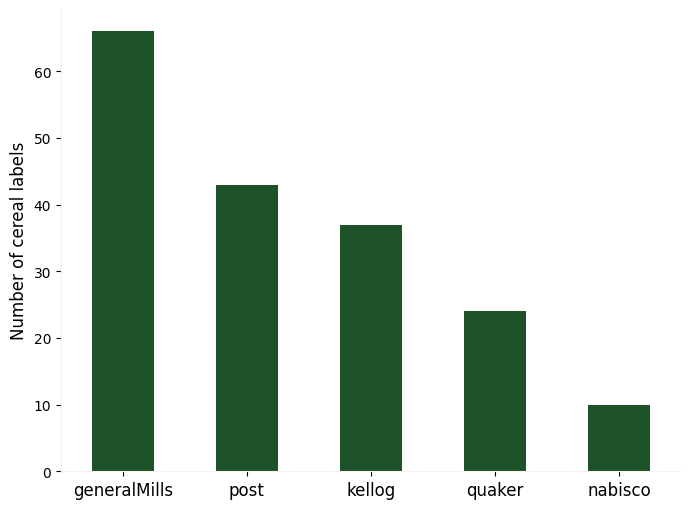

In [8]:
# Plots for the presentation about the data distribution

# Calculate number of differenet cereals in each brand
for idx, spine in enumerate(plt.gca().spines.values()):
    if idx in [1, 3]:
        spine.set_visible(False)
    else:
        spine.set_edgecolor(colors[0])
cereal.groupby("brand")["brand"].count().sort_values(ascending=False).plot(
    kind="bar", figsize=(8, 6), rot=0, color=colors[1]
)
plt.xticks(fontsize=12)
plt.xlabel(None)
plt.ylabel("Number of cereal labels", fontsize=12)
plt.savefig("graphs/brands_cereals_bar_count.png", bbox_inches="tight")
plt.show()

In [9]:
print(cereal.groupby("brand")["brand"].count().sort_values(ascending=False))

brand
generalMills    66
post            43
kellog          37
quaker          24
nabisco         10
Name: brand, dtype: int64


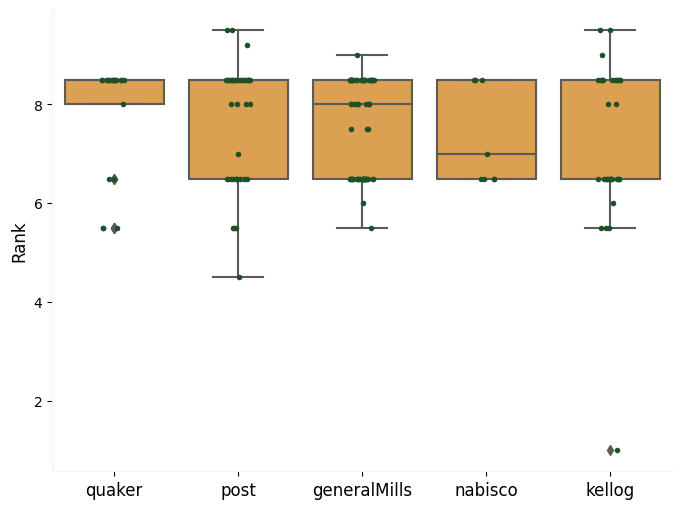

In [10]:
# Calculate the rank distribution in each brand
plt.figure(figsize=(8, 6))
for idx, spine in enumerate(plt.gca().spines.values()):
    if idx in [1, 3]:
        spine.set_visible(False)
    else:
        spine.set_edgecolor(colors[0])
ranks = cereal.groupby("brand")["rawGPTRank"].mean().sort_values()[::-1].index
sns.boxplot(x="brand", y="rawGPTRank", data=cereal, color=colors[4], order=ranks)
sns.stripplot(
    x="brand", y="rawGPTRank", data=cereal, color=colors[1], order=ranks, size=4
).set(xlabel=None)
plt.xticks(fontsize=12)
plt.xlabel(None)
plt.ylabel("Rank", fontsize=12)
plt.savefig("graphs/brands_rank_bar_count.png", bbox_inches="tight")
plt.show()

In [193]:
round(cereal_eda.groupby("brand")["Na_to_K"].mean().sort_values(ascending=False), 1)

brand
kellog          2.3
generalMills    1.6
post            0.7
quaker          0.1
nabisco         0.1
Name: Na_to_K, dtype: float64

In [185]:
cereal.groupby("rawGPTRank")["rawGPTRank"].count().sort_values(ascending=False)

rawGPTRank
8.5    75
6.5    55
8.0    16
5.5    10
9.5     4
7.5     3
6.0     2
7.0     2
9.0     2
1.0     1
4.5     1
9.2     1
Name: rawGPTRank, dtype: int64

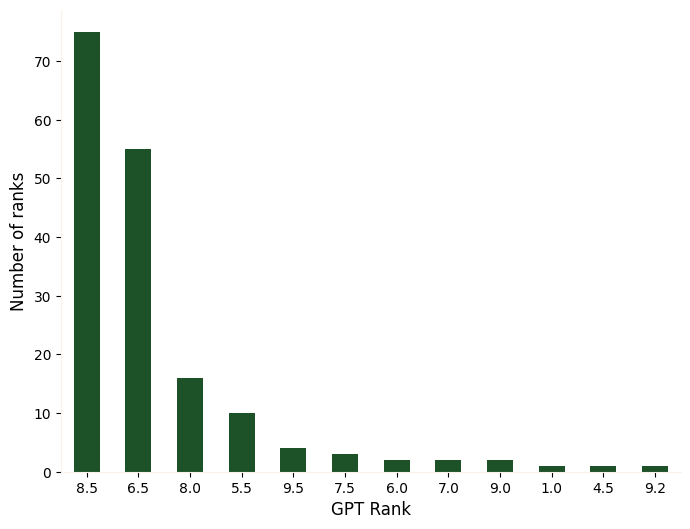

In [12]:
# Plotting bar graph with GPT rank count distribution
for idx, spine in enumerate(plt.gca().spines.values()):
    if idx in [1, 3]:
        spine.set_visible(False)
    else:
        spine.set_edgecolor(colors[0])
cereal.groupby("rawGPTRank")["rawGPTRank"].count().sort_values(ascending=False).plot(
    kind="bar", figsize=(8, 6), rot=0, color=colors[1]
)
plt.xlabel("GPT Rank", fontsize=12)
plt.ylabel("Number of ranks", fontsize=12)
plt.savefig("graphs/gptrank_bar_count.png", bbox_inches="tight")
plt.show()

/var/folders/cz/4jxvc_4j2jn8zpdd258vcz7w0000gn/T/ipykernel_21233/2373801988.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


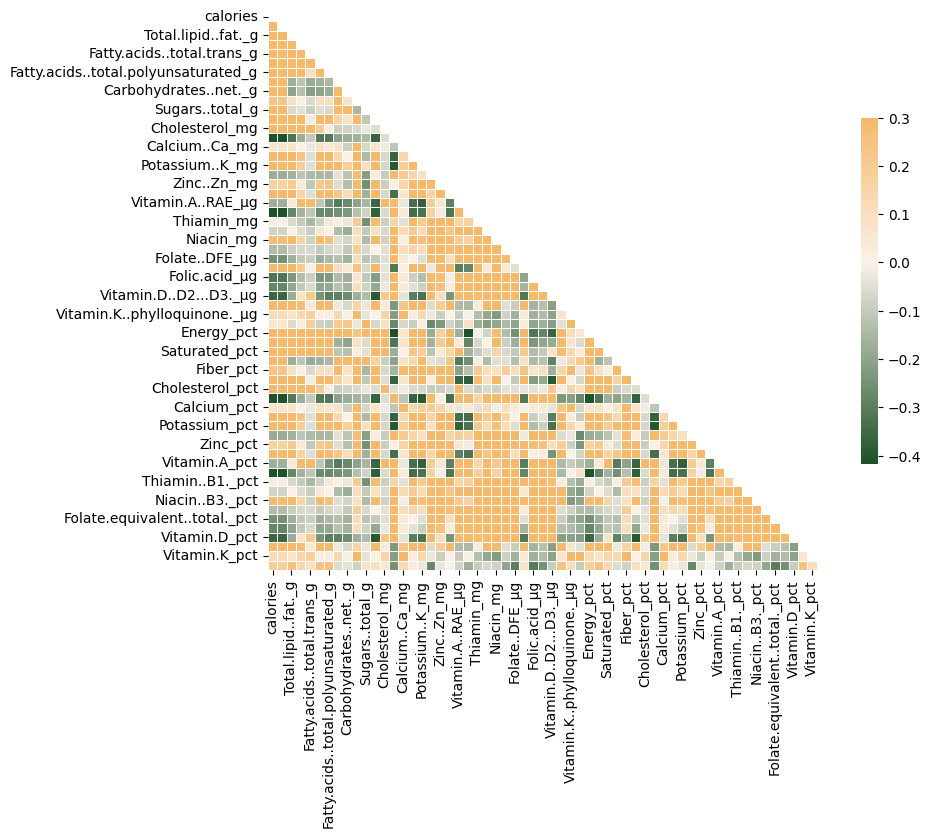

In [14]:
# Bivariate Analysis
# Correlation


def plot_corr(df, figsize=(9, 9), mask=None):
    corr = df.corr()
    if mask:
        mask = np.triu(
            np.ones_like(corr, dtype=bool)
        )  # Generate a mask for the upper triangle
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(110, -340, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr,
        cmap=custom_cmap,
        vmax=0.3,
        center=0,
        mask=mask,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
    )


plot_corr(cereal, mask=True)

<Figure size 1500x1500 with 0 Axes>

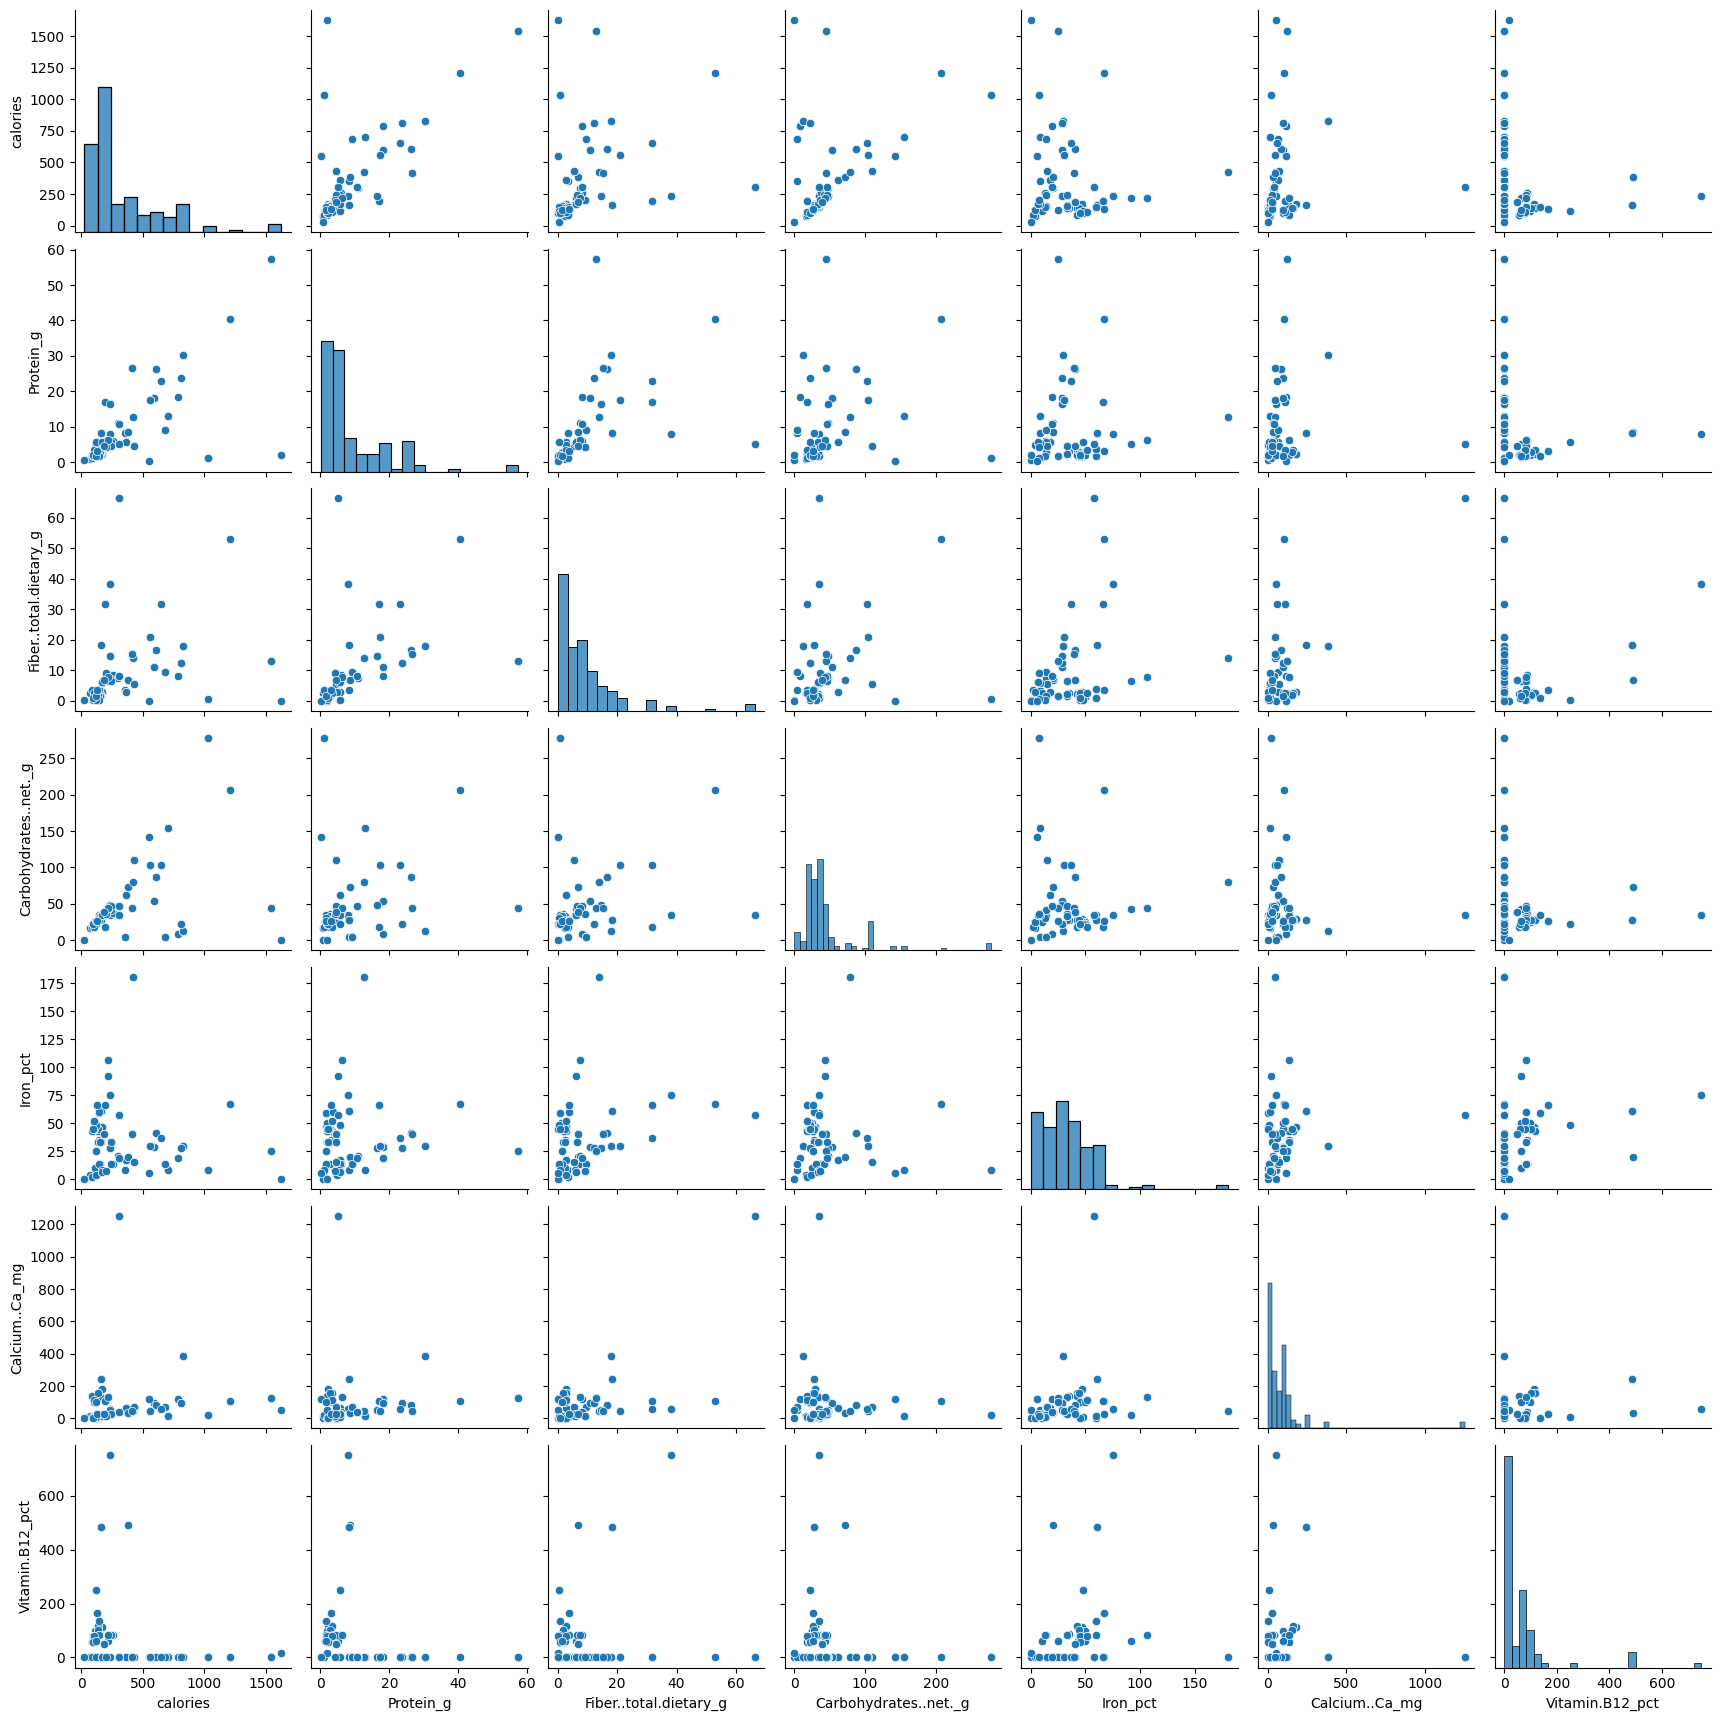

In [15]:
# Bivariate Analysis
plt.figure(figsize=(15, 15))
sns.pairplot(
    cereal[
        [
            "calories",
            "Protein_g",
            "Fiber..total.dietary_g",
            "Carbohydrates..net._g",
            "Iron_pct",
            "Calcium..Ca_mg",
            "Vitamin.B12_pct",
        ]
    ]
)  # pairplots to show correlation between selected features
plt.show()

### Micronutrient Density

In [16]:
# Micronutrient Density
# We can calculate micronutrient density by dividing the quantity of each micronutrient by the number of calories in each serving of cereal
# This will give us a measure of the amount of each nutrient per calorie, which is a good indicator of the "nutrient density" of each cereal
micronutrients_cols = list(cereal.columns[7:-2])
cereal_eda = cereal.copy()

for nutrient in micronutrients_cols:
    cereal_eda[nutrient + "_density"] = cereal_eda[nutrient] / cereal_eda["calories"]

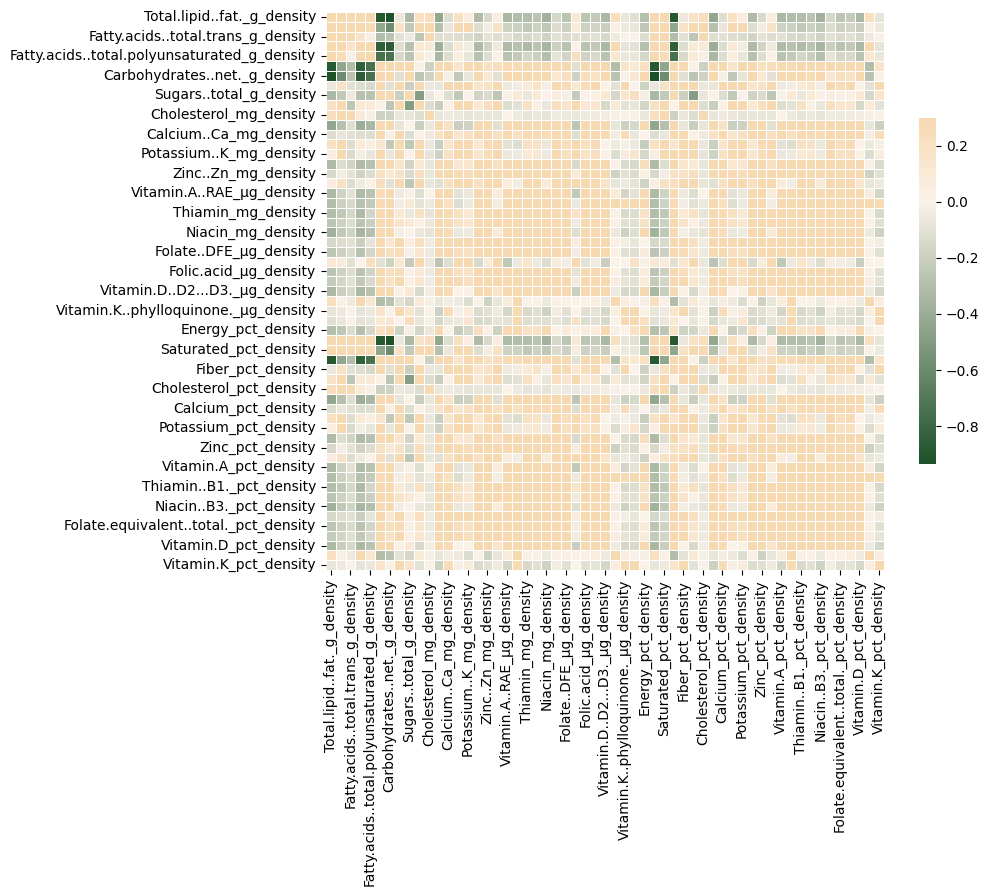

In [17]:
# Correlation Analysis: Compute correlations between the densities of different micronutrients
# This would tell you which nutrients tend to be found together in high-density cereals, which might suggest certain combinations of ingredients or manufacturing processes
plot_corr(cereal_eda[[col + "_density" for col in micronutrients_cols]])

In [18]:
# Ranking: Order cereals based on their micronutrient density
# We can identify which cereals are the most nutrient-dense for a given micronutrient
# This would provide insight into which cereals provide the most nutrients per calorie
for nutrient in popular_nutrients[1:]:  # to avoid looping throught calories feature
    cereal_eda.sort_values(by=nutrient + "_density", ascending=False, inplace=True)
    print(f"\nTop cereals for {nutrient} density:")
    print(cereal_eda[["cerealName", nutrient + "_density"]].head(10))


Top cereals for Protein_g density:
                   cerealName  Protein_g_density
105           Krispies, Cocoa            0.08602
89   Kellogg's Cocoa Krispies            0.08602
145              Puffs, Cocoa            0.08602
22             Cocoa Krispies            0.08602
35            Fiber, Oat Bran            0.07039
150   Quaker Oat Bran Squares            0.07039
118       Oat Bran High Fiber            0.07039
119          Oat Bran Squares            0.07039
182                Wheat Germ            0.06430
103     Kretschmer Wheat Germ            0.06430

Top cereals for Fiber..total.dietary_g density:
                       cerealName  Fiber..total.dietary_g_density
13        Cheerios-Apple Cinnamon                        0.215162
20                  Cinnamon Life                        0.215162
147          Quaker Cinnamon Life                        0.215162
1              All Bran Bran Buds                        0.165758
88   Kellogg's All Bran Bran Buds             

In [23]:
# Ratios
# https://www.nih.gov/news-events/nih-research-matters/sodium/potassium-ratio-linked-cardiovascular-disease-risk
# https://impactmagazine.ca/news-and-views/first-impact/the-five-to-one-fibre-rule/#:~:text=Here's%20how%20the%205%3A1,5%3A1%20ratio%20or%20less
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7589789/#:~:text=The%202015%E2%80%932020%20Dietary%20Guideline,%25%20of%20calories%20%5B12%5D
# Let's calculate the most important nutrients ratios to understand better what attract's customers

# Higher Sodium to Potassium ratios have been associated with higher risk of hypertension and cardiovascular diseases
cereal_eda["Na_to_K"] = cereal_eda["Sodium..Na_mg"] / cereal_eda["Potassium..K_mg"]
# Lower carbohydrate to fiber ratios are generally considered healthier and more beneficial for managing blood sugar levels
cereal_eda["Carb_to_Fiber"] = (
    cereal_eda["Carbohydrate..by.difference_g"] / cereal_eda["Fiber..total.dietary_g"]
)
# Can be useful in assessing the nutritional profile of the cereal
cereal_eda["Protein_to_Fat"] = (
    cereal_eda["Protein_g"] / cereal_eda["Total.lipid..fat._g"]
)

### Brand Comparison

In [83]:
round(cereal_eda.groupby("brand")["Carb_to_Fiber"].mean().sort_values()[::-1], 2)

brand
kellog            NaN
generalMills      NaN
post            28.84
nabisco          6.55
quaker           6.28
Name: Carb_to_Fiber, dtype: float64

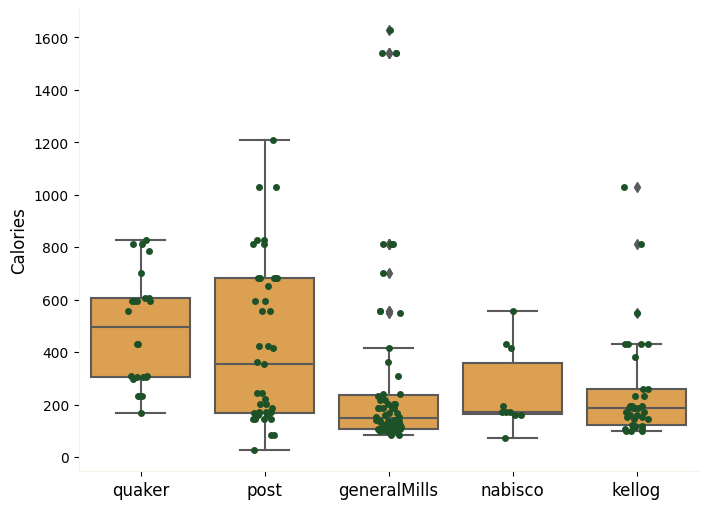

In [90]:
# Plot boxplots by calories value
plt.figure(figsize=(8, 6))
for idx, spine in enumerate(plt.gca().spines.values()):
    if idx in [1, 3]:
        spine.set_visible(False)
    else:
        spine.set_edgecolor(colors[0])
ranks = cereal_eda.groupby("brand")["calories"].mean().sort_values()[::-1].index
sns.boxplot(x="brand", y="calories", data=cereal_eda, color=colors[4], order=ranks)
sns.stripplot(x="brand", y="calories", data=cereal_eda, color=colors[1], order=ranks)
plt.xticks(fontsize=12)
plt.xlabel(None)
plt.ylabel("Calories", fontsize=12)
plt.savefig(f"graphs/calories_boxplot.png", bbox_inches="tight")
plt.show()

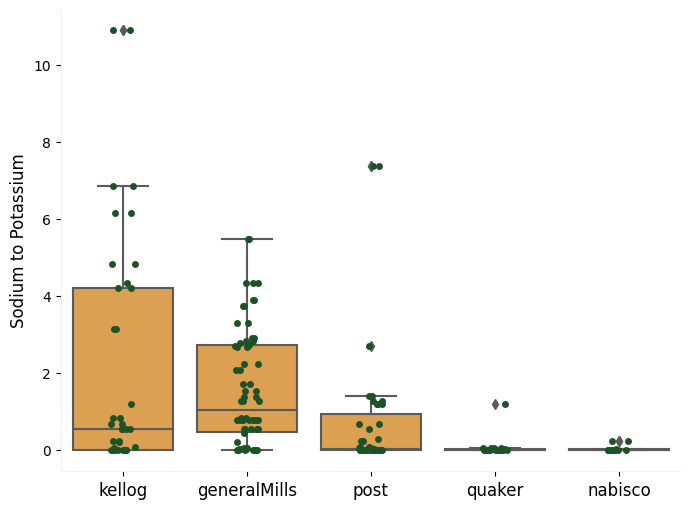

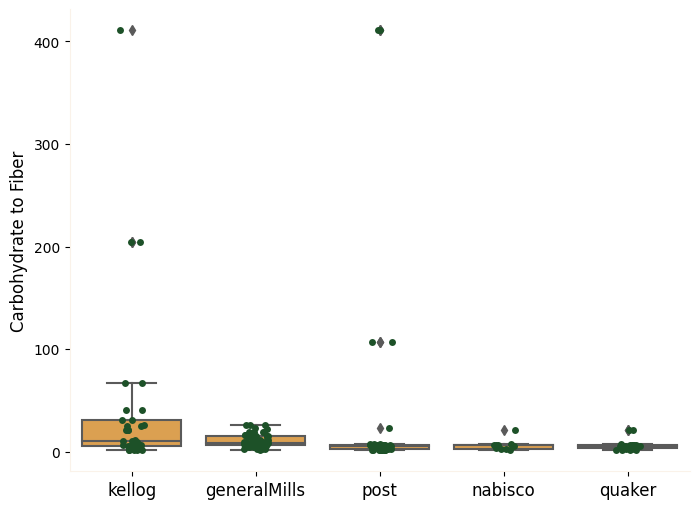

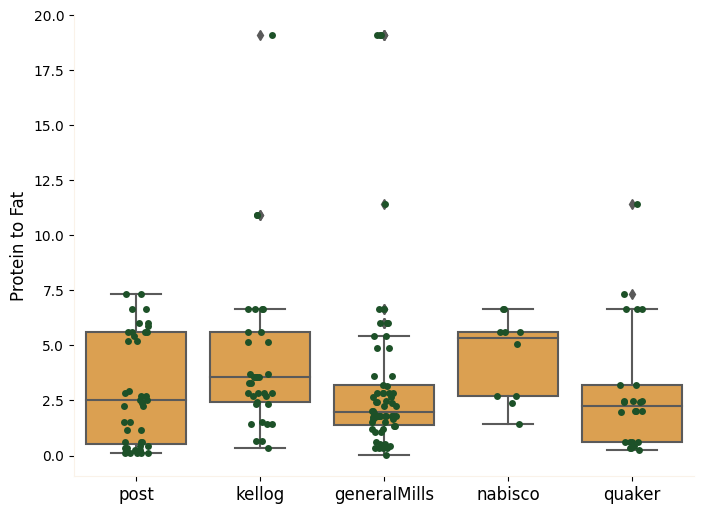

In [71]:
# Plot the ratios distribution for each brand
y_labels = ["Sodium to Potassium", "Carbohydrate to Fiber", "Protein to Fat"]
for idy, ratio in enumerate(["Na_to_K", "Carb_to_Fiber", "Protein_to_Fat"]):
    plt.figure(figsize=(8, 6))
    for idx, spine in enumerate(plt.gca().spines.values()):
        if idx in [1, 3]:
            spine.set_visible(False)
        else:
            spine.set_edgecolor(colors[0])
    ranks = cereal_eda.groupby("brand")[ratio].mean().sort_values()[::-1].index
    sns.boxplot(x="brand", y=ratio, data=cereal_eda, color=colors[4], order=ranks)
    sns.stripplot(x="brand", y=ratio, data=cereal_eda, color=colors[1], order=ranks)
    plt.xticks(fontsize=12)
    plt.xlabel(None)
    plt.ylabel(y_labels[idy], fontsize=12)
    plt.savefig(f"graphs/{ratio}_boxplot.png", bbox_inches="tight")
    plt.show()

In [25]:
# Same as ranking and ordering cereals based on their micronutrient density
# But here we use absolute values instead of densities
for nutrient in popular_nutrients:
    df_plot = df_exploded.sort_values(by=[nutrient], ascending=False)
    df_plot = df_plot.drop_duplicates(
        subset=["brand"]
    )  # we want to see only cereal with the highest nutrient for each brand
    print(nutrient)
    print(
        *zip(
            df_plot.loc[:, "brand"],
            df_plot.loc[:, "cerealName"],
            df_plot.loc[:, nutrient],
            df_plot.loc[:, "rawGPTRank"],
        )
    )  # Zip together values for the better viz
    print()

calories
('generalMills', 'Puffs, Peenut Butter', 1627, 8.5) ('post', 'Post Wheat and Barley', 1207, 5.5) ('kellog', 'Corn Flakes, Honey Crunch', 1030, 8.5) ('quaker', 'Healthy Choice Mueslix Raisin & Almond Crunch', 827, 8.5) ('nabisco', 'Wheat', 556, 6.5)

Protein_g
('generalMills', "Peanut Butter Puffs - Reese's General Mills)", 57.3, 8.5) ('post', 'Post Wheat and Barley', 40.35, 5.5) ('quaker', 'Healthy Choice Mueslix Raisin & Almond Crunch', 30.24, 8.5) ('nabisco', 'Kretschmer Wheat Germ', 26.62, 8.5) ('kellog', 'Just Right with Fruit and Nuts', 23.7, 6.5)

Fiber..total.dietary_g
('generalMills', 'Cheerios-Apple Cinnamon', 66.27, 8.0) ('quaker', 'Quaker Cinnamon Life', 66.27, 8.5) ('post', 'Post Wheat and Barley', 52.83, 5.5) ('kellog', "Kellogg's All Bran Bran Buds", 38.29, 1.0) ('nabisco', 'Krispies, Cocoa', 31.82, 6.5)

Carbohydrates..net._g
('kellog', 'Corn Flakes, Honey Crunch', 278.66, 8.5) ('post', 'Post Honey Bunches of Oats Honey Roasted', 278.66, 8.5) ('generalMills', 'C

In [26]:
# Instead of printing cereals for each brand, let's print 15 cereals with the highest selected nutrient
for nutrient in popular_nutrients:
    df_plot = df_exploded.sort_values(by=[nutrient], ascending=False)
    df_plot = df_plot.drop_duplicates(subset=["cerealName"])
    print(nutrient)
    print(
        *zip(
            df_plot.loc[df_plot.index[:15], "brand"],
            df_plot.loc[df_plot.index[:15], "cerealName"],
            df_plot.loc[df_plot.index[:15], nutrient],
            df_plot.loc[df_plot.index[:15], "rawGPTRank"],
        )
    )
    print()

calories
('generalMills', 'Puffs, Peenut Butter', 1627, 8.5) ('generalMills', "Peanut Butter Puffs - Reese's General Mills)", 1542, 8.5) ('generalMills', "Reese's Peanut Butter Puffs", 1542, 8.5) ('generalMills', "General Mills Reese's Peanut Butter Puffs", 1542, 8.5) ('post', 'Post Wheat and Barley', 1207, 5.5) ('kellog', 'Corn Flakes, Honey Crunch', 1030, 8.5) ('post', 'Post Honey Bunches of Oats Honey Roasted', 1030, 8.5) ('post', 'Honey Bunches of Oats Honey Roasted', 1030, 8.5) ('quaker', 'Healthy Choice Mueslix Raisin & Almond Crunch', 827, 8.5) ('post', 'Honey Bunches of Oats with Almonds', 827, 9.5) ('post', 'Post Honey Bunches of Oats with Almonds', 827, 9.5) ('kellog', 'Just Right with Fruit and Nuts', 813, 6.5) ('quaker', "Honey Nut Oh's", 813, 5.5) ('generalMills', 'Chex, Honey Nut', 813, 8.0) ('generalMills', 'Honey Nut Clusters', 813, 8.5)

Protein_g
('generalMills', "Peanut Butter Puffs - Reese's General Mills)", 57.3, 8.5) ('generalMills', "Reese's Peanut Butter Puffs",

### Clusterization

In [27]:
# Perform clusterization to find insights or meaningful data
numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]

# Selecting only numerical columns
cereal_filled = cereal.select_dtypes(include=numerics)

# Imput the missing values with the k-Nearest Neighbors method
imputer = KNNImputer(n_neighbors=7)
cereal_filled = imputer.fit_transform(cereal_filled)

scaler = StandardScaler()
cereal_scaled = scaler.fit_transform(cereal_filled)

/Users/LS/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/LS/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/LS/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/LS/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/LS/anaconda3/lib/python3.

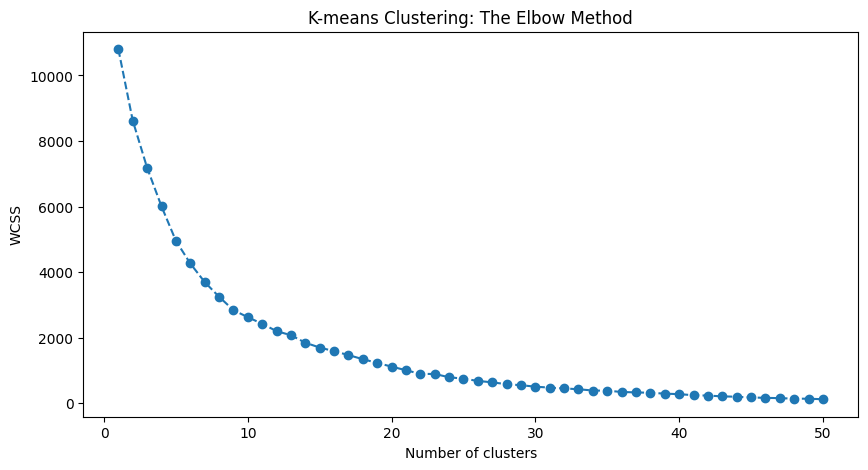

In [28]:
# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 51):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(cereal_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the resultant graph to find the optimal number of clusters
plt.figure(figsize=(10, 5))
plt.plot(range(1, 51), wcss, marker="o", linestyle="--")
plt.title("K-means Clustering: The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [72]:
# We found that the mot optimal number of clusters is 8
kmeans = KMeans(n_clusters=8)
clusters = kmeans.fit_predict(cereal_scaled)

# Add the cluster number to the dataframe
cereal_eda["cluster"] = clusters

/Users/LS/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [73]:
# add the cluster assignments back into the dataframe
cereal["cluster_mean_values"] = kmeans.labels_

# Group by cluster
grouped = cereal.groupby("cluster_mean_values")
cereal = cereal.drop(columns="cluster_mean_values")

# Compute mean value of each feature per cluster
mean_values = grouped.mean()

/var/folders/cz/4jxvc_4j2jn8zpdd258vcz7w0000gn/T/ipykernel_21233/1483665518.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_values = grouped.mean()


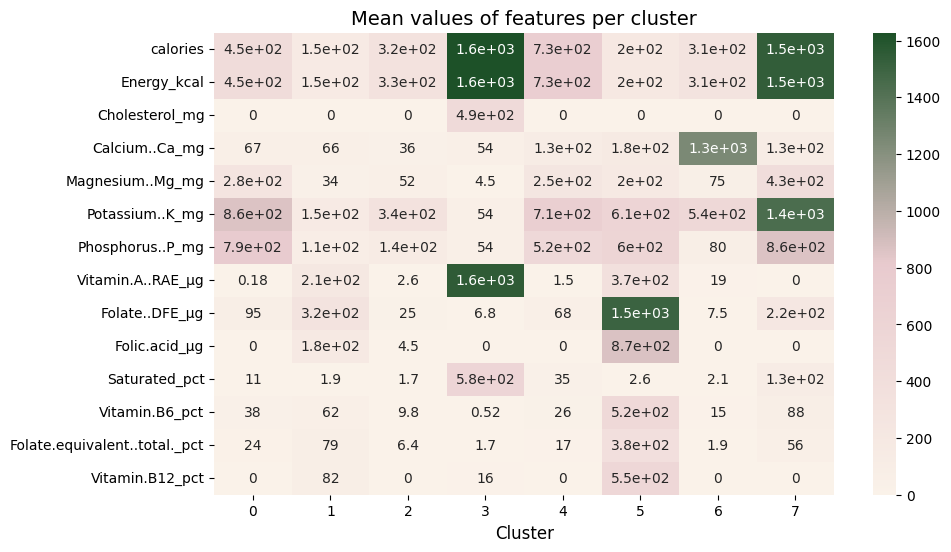

In [74]:
# Transpose the DataFrame for easier plotting
mean_values_t = mean_values.transpose()

# Plot mean values of features for each cluster
plt.figure(figsize=(10, 6))
sns.heatmap(
    mean_values_t.loc[
        mean_values_t[mean_values_t > 300].dropna(axis=0, how="all").index
    ],
    cmap=custom_cmap_cluster,
    annot=True,
)
plt.title("Mean values of features per cluster", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel(None)
plt.savefig("graphs/mean_values_cluster.png", bbox_inches="tight")
plt.show()

In [176]:
round(cereal_eda.groupby("cluster")["rawGPTRank"].mean().loc[x], 1)

cluster
1    7.4
2    7.6
4    7.7
0    7.7
5    7.6
6    8.3
7    7.5
3    8.5
Name: rawGPTRank, dtype: float64

In [169]:
# Each cluster gets its own name based on the mean values of features
cluster_names = [
    "(0) High Energy & Minerals Cereal",
    "(1) Low Calorie & High Folate Cereal",
    "(2) Moderate Energy Cereal",
    "(3) High-Calorie & High-Cholesterol Cereal",
    "(4) Energy-Dense & High-Calcium Cereal",
    "(5) Low Calorie & High Vitamin B Cereal",
    "(6) High Calcium & Moderate Energy Cereal",
    "(7) High Energy & High Magnesium Cereal",
]

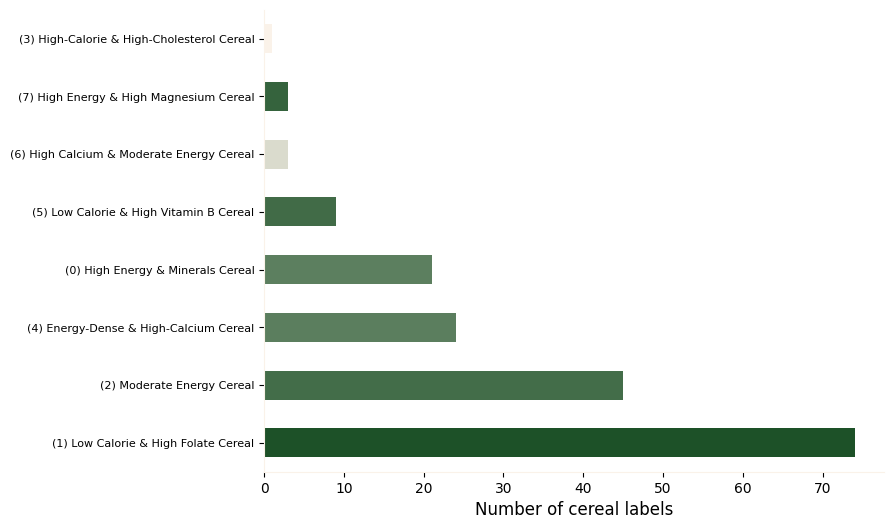

In [174]:
cmap_bar = LinearSegmentedColormap.from_list("custom_cmap", [colors[1], colors[0]])

# Plotting size of each cluster using bar chart and color them based on the mean Rank value in each cluster
for idx, spine in enumerate(plt.gca().spines.values()):
    if idx in [1, 3]:
        spine.set_visible(False)
    else:
        spine.set_edgecolor(colors[0])
cluster_index = list(
    cereal_eda.groupby("cluster")["cluster"].count().sort_values(ascending=False).index
)
cluster_values_by_rank = (
    cereal_eda.groupby("cluster")["rawGPTRank"].mean().loc[x].values
)
cereal_eda.groupby("cluster")["cluster"].count().sort_values(ascending=False).plot(
    kind="barh",
    figsize=(8, 6),
    color=cmap_bar(
        (cluster_values_by_rank - cluster_values_by_rank.min())
        / (cluster_values_by_rank.max() - cluster_values_by_rank.min())
    ),
)
plt.yticks(
    range(0, 8), [cluster_names[i] for i in x], fontsize=8, rotation="horizontal"
)
plt.ylabel(None)
plt.xlabel("Number of cereal labels", fontsize=12)
plt.savefig("graphs/clusters_bar_count.png", bbox_inches="tight")
plt.show()

### Outliers

In [32]:
# Detecting outliers
# Let's use Isolation Forest this time
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.01)
outliers = clf.fit_predict(cereal_scaled)

# Add the outlier predictions to the dataframe
cereal_eda["outlier"] = outliers

In [33]:
# Print outliers
print(
    cereal[cereal_eda["outlier"] == -1].loc[
        :, ["cerealName", "brand", "rawGPTRank", "gptDescription"]
    ]
)

                      cerealName         brand  rawGPTRank  \
53   General Mills Oatmeal Crisp  generalMills         6.5   
172      Toasted Oatmeal, Quaker        quaker         8.5   

                                        gptDescription  
53   General Mills Oatmeal Crisp :  is a wholesome ...  
172  Toasted Oatmeal, Quaker :  is a classic honey ...  


/var/folders/cz/4jxvc_4j2jn8zpdd258vcz7w0000gn/T/ipykernel_21233/3196792557.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(cereal[cereal_eda['outlier'] == -1].loc[:, ['cerealName', 'brand', 'rawGPTRank', 'gptDescription']])


### Dimentionality Reduction

In [34]:
# For the purpose of EDA, let's perform non-linear DR and plot the results in 3d space

tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(cereal_scaled)

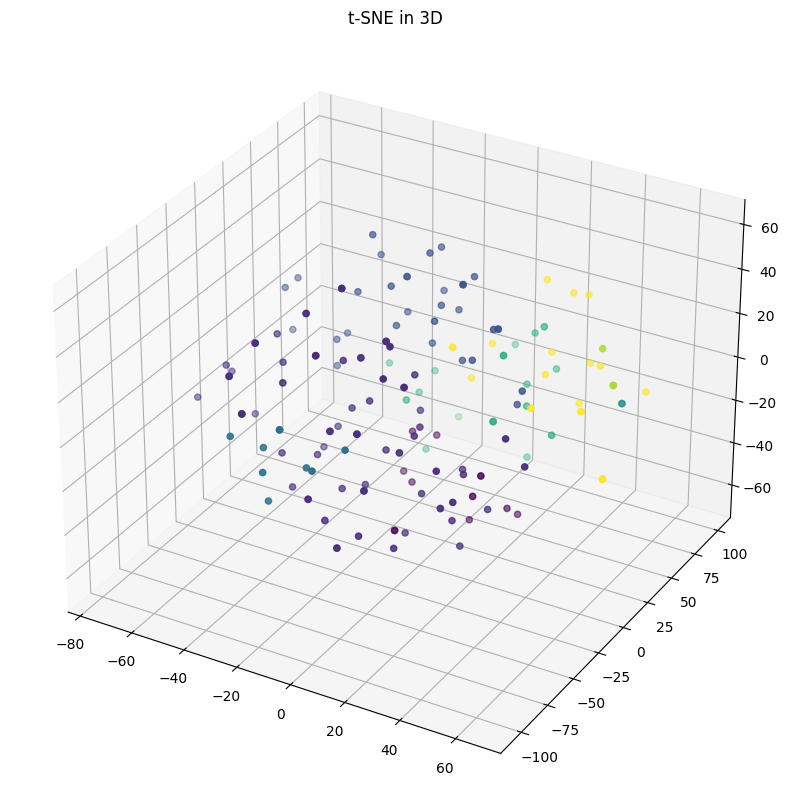

In [35]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=cereal_eda["cluster"])
ax.set_title("t-SNE in 3D")
plt.show()

In [36]:
# Also we can try Isomap

iso = Isomap(n_components=3)
iso.fit(cereal_scaled)
cereal_isomap = iso.transform(cereal_scaled)

/Users/LS/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:352: UserWarning: The number of connected components of the neighbors graph is 7 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/LS/anaconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/LS/anaconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/LS/anaconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Us

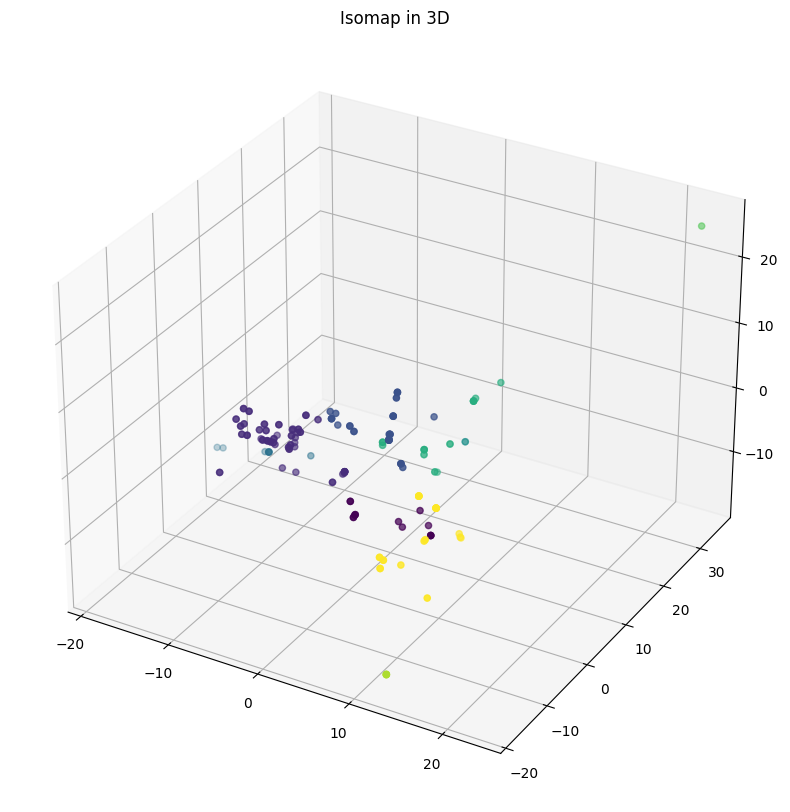

In [37]:
# Plot isomap and color it based on the cluster we estimated

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    cereal_isomap[:, 0],
    cereal_isomap[:, 1],
    cereal_isomap[:, 2],
    c=cereal_eda["cluster"],
)
ax.set_title("Isomap in 3D")
plt.show()

In [38]:
# Achived vectors can be used as inputs in the model, but as we want to interpritate out results, we must use features we understand

### Modeling

In [48]:
# Function to drop highly correlated features
def drop_corr_features(df, threshold=0.5):
    # Filter highly correlated features
    correlation_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool)
    )

    # Find features with correlation greater than a threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop highly correlated features
    df_dropped = df.drop(df[to_drop], axis=1)

    return df_dropped

In [56]:
# Create dataset from the scaled and filled values
columns = cereal.iloc[:, 5:-1].columns
cereal_filled_df = drop_corr_features(pd.DataFrame(cereal_filled, columns=columns))
cereal_scaled_df = drop_corr_features(pd.DataFrame(cereal_scaled, columns=columns))
feature_names = list(cereal_filled_df.columns[:-1])

X = cereal_filled_df.iloc[:, :-1]
y = cereal_filled_df["rawGPTRank"]

X["cluster"] = clusters
feature_names.append("cluster")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = DecisionTreeRegressor(max_depth=7).fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

MAE:  0.6606448954809608
MSE:  0.8861317704991163
RMSE:  0.9413457231533569


/var/folders/cz/4jxvc_4j2jn8zpdd258vcz7w0000gn/T/ipykernel_21233/1800885221.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
/var/folders/cz/4jxvc_4j2jn8zpdd258vcz7w0000gn/T/ipykernel_21233/1800885221.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecation

In [57]:
# Print the decision tree
text_representation = tree.export_text(decision_tree=model, feature_names=feature_names)
print(text_representation)

|--- calories <= 146.00
|   |--- Carbohydrate..by.difference_g <= 22.04
|   |   |--- Sodium..Na_mg <= 141.10
|   |   |   |--- calories <= 49.50
|   |   |   |   |--- value: [8.50]
|   |   |   |--- calories >  49.50
|   |   |   |   |--- cluster <= 1.50
|   |   |   |   |   |--- value: [7.64]
|   |   |   |   |--- cluster >  1.50
|   |   |   |   |   |--- Vitamin.C..total.ascorbic.acid_mg <= 9.51
|   |   |   |   |   |   |--- value: [7.00]
|   |   |   |   |   |--- Vitamin.C..total.ascorbic.acid_mg >  9.51
|   |   |   |   |   |   |--- value: [7.25]
|   |   |--- Sodium..Na_mg >  141.10
|   |   |   |--- value: [6.50]
|   |--- Carbohydrate..by.difference_g >  22.04
|   |   |--- Fiber..total.dietary_g <= 2.78
|   |   |   |--- Fiber..total.dietary_g <= 2.22
|   |   |   |   |--- Water_g <= 0.99
|   |   |   |   |   |--- value: [6.50]
|   |   |   |   |--- Water_g >  0.99
|   |   |   |   |   |--- Sodium..Na_mg <= 218.70
|   |   |   |   |   |   |--- Carbohydrate..by.difference_g <= 27.27
|   |   |   |  

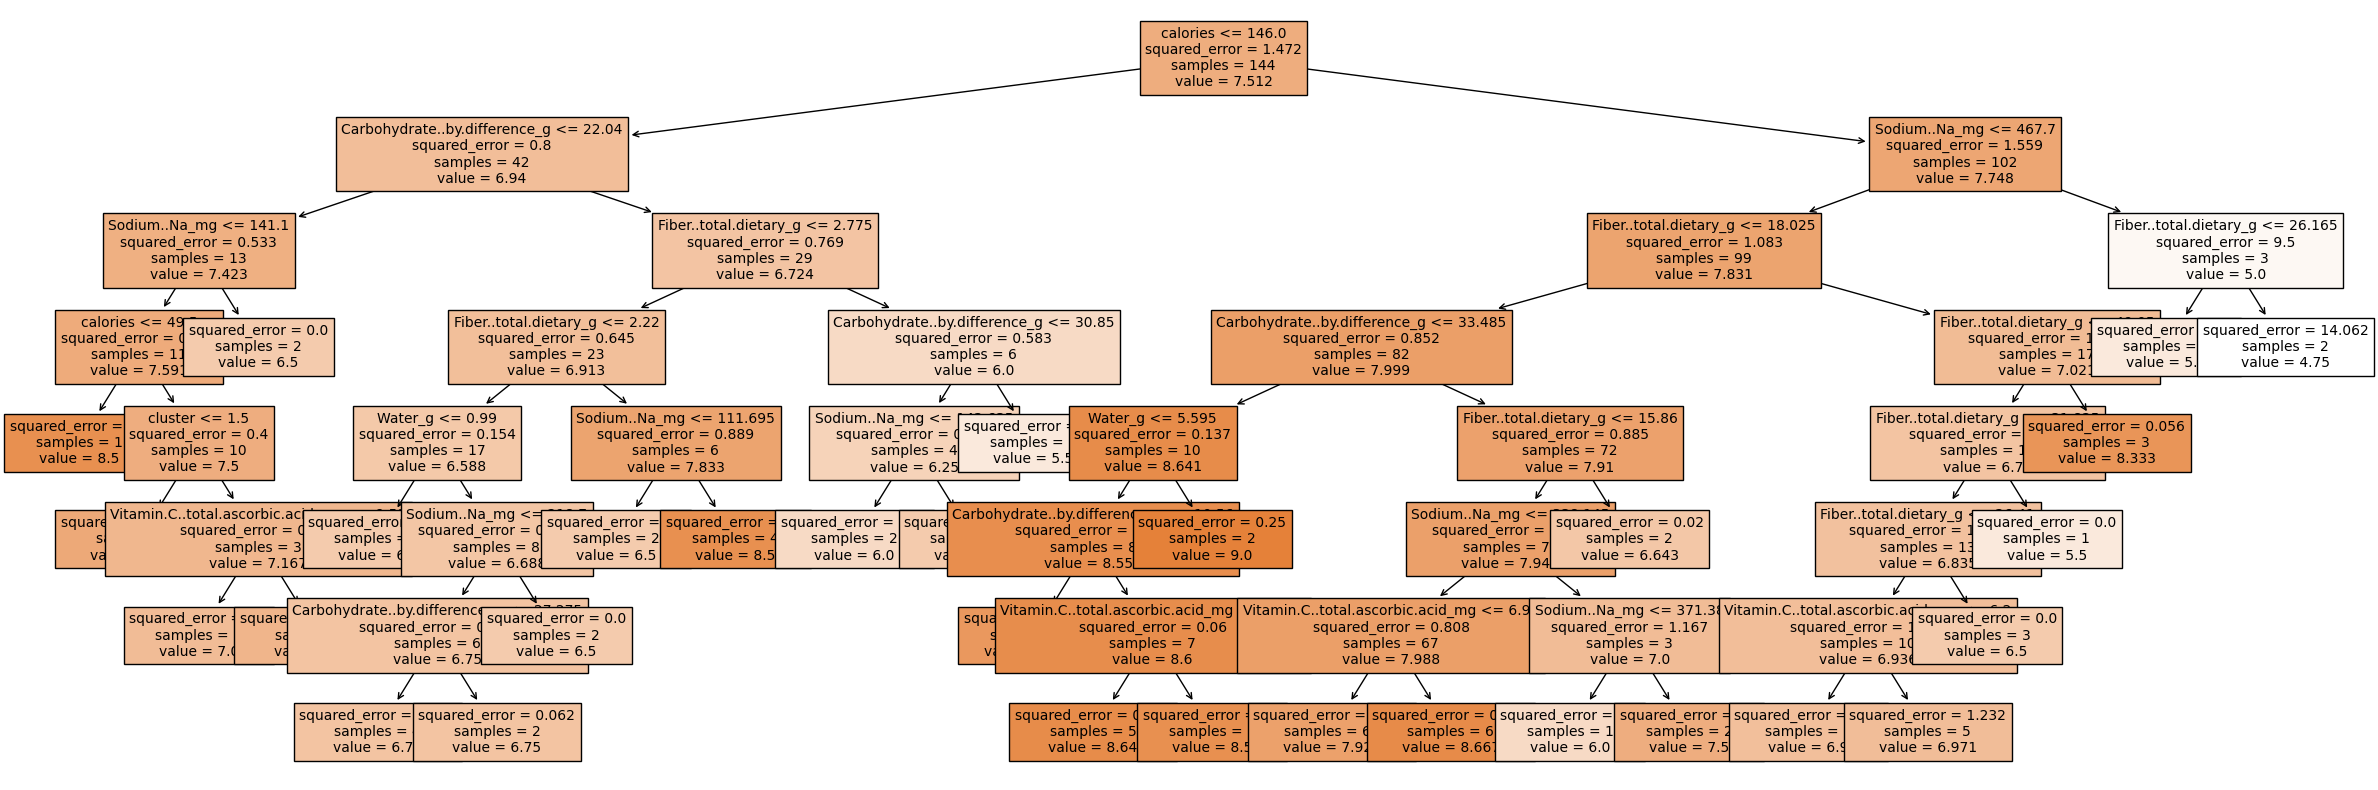

In [58]:
# Plot the decision tree
fig = plt.figure(figsize=(30, 10))
_ = tree.plot_tree(
    model,
    feature_names=feature_names,
    class_names="rawGPTRank",
    filled=True,
    fontsize=10,
)

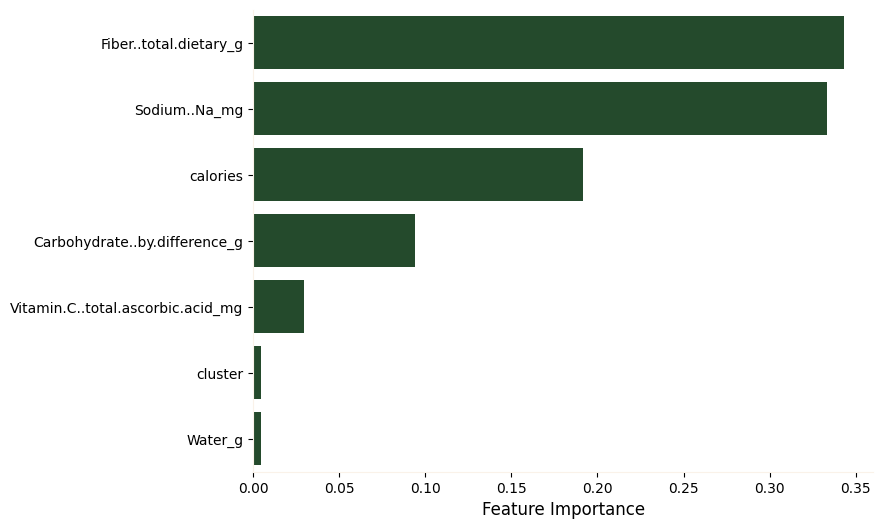

In [182]:
# Extracting feature importance from the model and plotting
importance = pd.DataFrame(
    {"Feature": feature_names, "Importance": model.feature_importances_}
)
importance.sort_values("Importance", ascending=False, inplace=True)

plt.figure(figsize=(8, 6))
for idx, spine in enumerate(plt.gca().spines.values()):
    if idx in [1, 3]:
        spine.set_visible(False)
    else:
        spine.set_edgecolor(colors[0])
sns.barplot(data=importance, y="Feature", x="Importance", color=colors[1], orient="h")

plt.ylabel(None)
plt.xlabel("Feature Importance", fontsize=12)
plt.savefig("graphs/feature_importance.png", bbox_inches="tight")
plt.show()

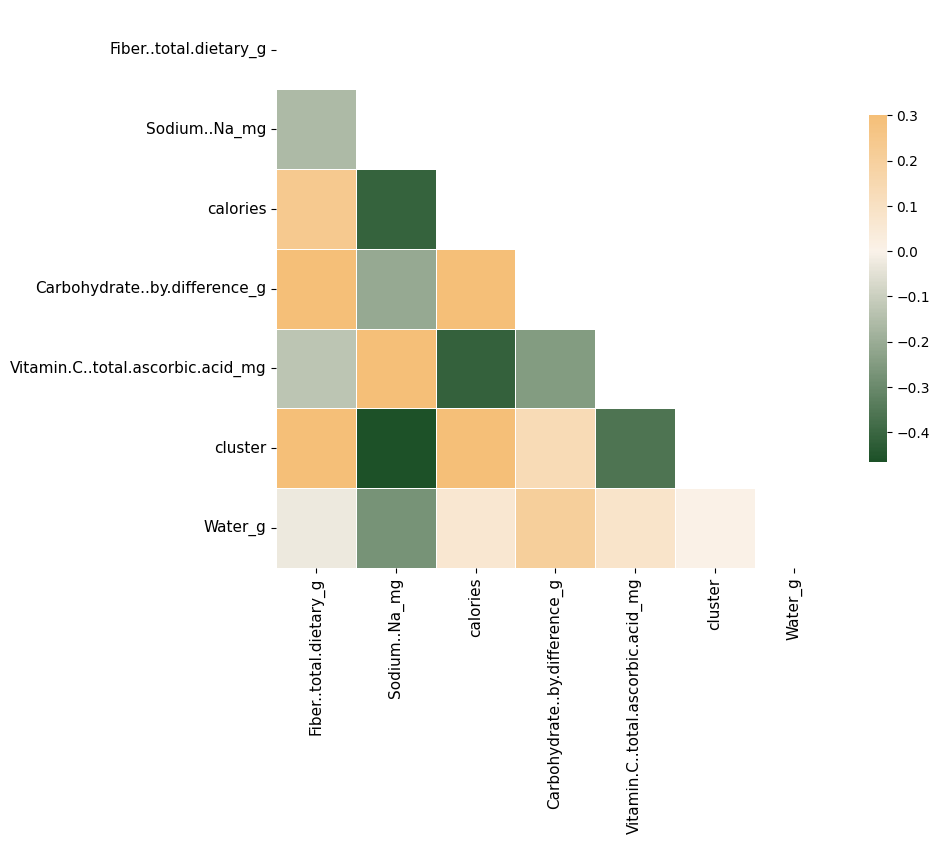

In [60]:
# Plot correlation between the most important features in the model
cereal["cluster"] = clusters
plot_corr(cereal[importance.iloc[:, 0].values], mask=True)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.savefig("graphs/corr_important_features.png", bbox_inches="tight")
plt.show()
cereal = cereal.drop(columns="cluster")